## Stochastic Jump Processes: Application to Exothermic Reactions in CSTRs

Rafif S. Ramadhan (Purdue University Davidson School of Chemical Engineering)

#### Generic (Deterministic) CSTR

We first model a CSTR of contant volume $V_R$ where the reaction $A\rightarrow B$ occurs.
Component A is fed to the reactor at $T_f$ and concentration $C_{A,f}$.
The outflow contains A and B at reactor temperature $T$ and concentrations $C_A, C_B$
The governing equations are:

$$\frac{dC_A}{dt} = \frac{F}{V_R}\left(C_{Af} - C_A\right) - r, \\[6pt]
\frac{dT}{dt} = \frac{F}{V_R}(T_f - T) - \frac{\Delta H}{\rho C_P}\, r, \\[6pt]
r = k_0\, C_A \exp\!\left(-\frac{E}{RT}\right).$$

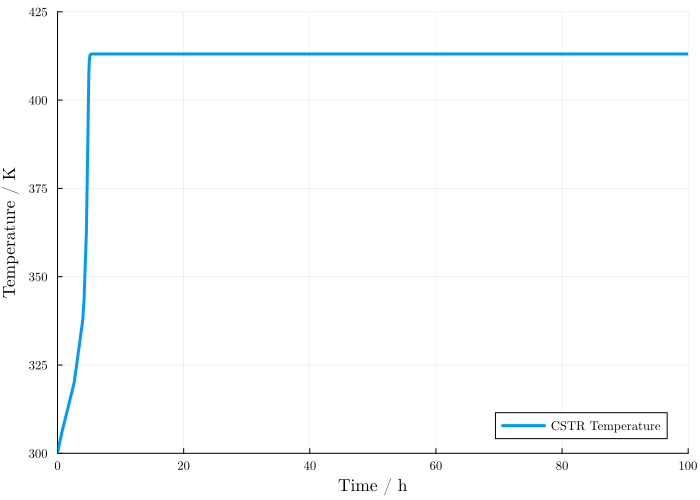

In [4]:
# Setup packages
using DifferentialEquations
using Plots
default(fontfamily="Computer Modern") # Sets "Computer Modern" as the default font for all plot elements

# Define the ODE function
function cstr!(du, u, p, t)
    
    # Unpack variables
    C_A, T = u

    # Unpack parameters
    F, V, C_Af, Tf, k0, E, R, ΔH, ρCp,  = p

    # Reaction rate
    k = k0 * exp(-E / (R * T))

    # ODEs
    dC_Adt = (F/V) * (C_Af - C_A) - k * C_A
    dTdt = (F/V) * (Tf - T) + (-ΔH/(ρCp)) * k * C_A

    # Assign derivatives
    du[1] = dC_Adt
    du[2] = dTdt
end

# Parameters
F = 1.0             # Flow rate (m3/h)
V = 1.0             # Volume of reactor (m3)
C_Af = 10.0         # Inlet concentration of A (mol/m3)
Tf = 300.0          # Inlet temperature (K)
k0 = 35e6           # Pre-exponential factor (1/h)
E = 49.56e3         # Activation energy (J/mol)
R = 8.314           # Gas constant (J/(mol*K))
ΔH = -25e6          # Heat of reaction (J/mol)
ρCp = 2.1e6         # Heat capacity (J/(m3*K))

# Define the SDE parameters
sig_C = 0.05        # Noise intensity for concentration
sig_T = 0.005       # Noise intensity for temperature

p_sde = (F, V, C_Af, Tf, k0, E, R, ΔH, ρCp, sig_C, sig_T)

# Initial conditions
C_A0 = 10           # Initial concentration of A (mol/m3)
T0 = 300.0          # Initial temperature (K)
u0 = [C_A0, T0]
T = 100.0           # Total simulation time (h)
tspan = (0.0, T)    # Time span (h)
dt = 0.1            # Time step for saving solution
tsteps = 0.0:dt:T   # Time steps for saving solution

# Define the ODE problem
odeprob = ODEProblem(cstr!, u0, tspan, p_sde)

# Solve the ODE problem
odesol = solve(odeprob, Tsit5())

# Plot the temperature profile
plot(odesol.t, [u[2] for u in odesol.u], xlabel="Time / h", ylabel="Temperature / K", legend=true, lw=3, label="CSTR Temperature")
plot!(ylims=(300,425), xlims=(0,100), size=(700,500))

#### Generic (Stochastic) CSTR

We can write the SDEs in Ito's form:

$$
dC_A = \left[\frac{F}{V_R}\left(C_{Af} - C_A\right) - r)\right]\,dt+\sigma_{C_A}\,C_A\,dW_t^{(1)},\\[6pt]
dT = \left[\frac{F}{V_R}(T_f - T) - \frac{\Delta H}{\rho C_P}\, r\right]\,dt+\sigma_T\,(T-270K)^{1.5}\,dW_t^{(2)}.
$$

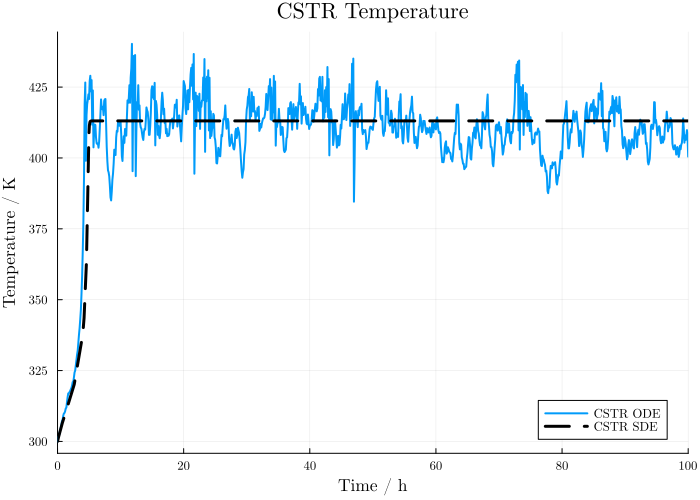

In [5]:
# Diffusion term
function cstr_noise!(du, u, p, t)
    # Unpack variables
    C_A, T = u

    # Unpack parameters
    F, V, C_Af, Tf, k0, E, R, ΔH, ρCp, sig_C, sig_T = p

    # Noise terms
    du[1] = sig_C * C_A
    du[2] = sig_T * sign(T - 270) * abs(T - 270)^1.5
end

# Define the SDE problem
sdeprob = SDEProblem(cstr!, cstr_noise!, u0, tspan, p_sde)

# Solve the SDE problem
sdesol = solve(sdeprob, EM(), dt=dt, saveat=tsteps)

# Plot the temperature profile from SDE
plot(sdesol.t, [u[2] for u in sdesol.u], xlabel="Time / h", ylabel="Temperature / K", legend=true, lw=2, label="CSTR ODE", title="CSTR Temperature")
plot!(odesol.t, [u[2] for u in odesol.u], lw=3, label="CSTR SDE", linestyle=:dash, color=:black)
plot!(xlims=(0,100), size=(700,500))

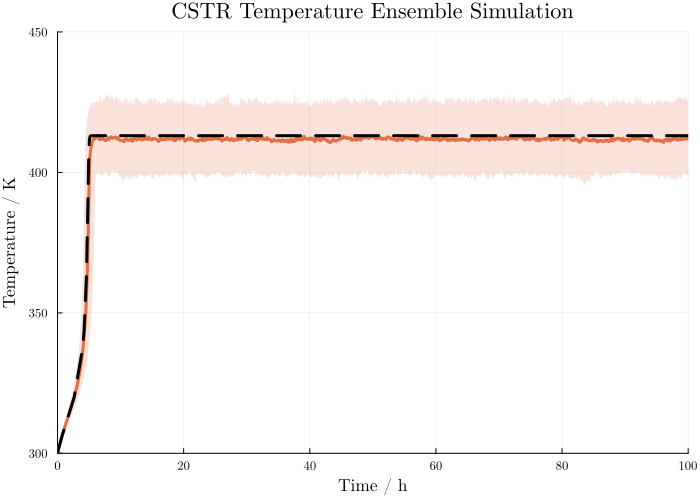

In [6]:
# Ensemble simulation
ensemble_prob = EnsembleProblem(sdeprob, prob_func = (prob,i,repeat) -> remake(prob))
ensemble_sol = solve(ensemble_prob, EM(), EnsembleThreads(), trajectories=500, dt=dt, saveat=tsteps)
summ = EnsembleSummary(ensemble_sol)

plot(summ;idxs=2, xlabel="Time / h", ylabel="Temperature / K", lw=3, ylims=(300,450), xlims=(0,100), size=(700,500), title="CSTR Temperature Ensemble Simulation")
plot!(odesol.t, [u[2] for u in odesol.u], lw=3, linestyle=:dash, color=:black)

#### Generic (Stochastic) CSTR with Jumps

We add a jump term to the Ito temperature SDE to model random thermal runaways.

$$dT = \left[\frac{F}{V_R}(T_f - T) - \frac{\Delta H}{\rho C_P}\, r\right]\,dt+\sigma_T\,(T-270K)^{1.5}\,dW_t^{(2)} + \kappa_T\,dL_t^{(C)}$$